# Cloudy-skies: DISC

The NSRDB [website](https://nsrdb.nrel.gov/data-sets/us-data) claims that the DISC model is used for cloudy-sky GHI decomposition:

> PSM uses a two-step process where cloud properties are retrieved using the adapted PATMOS-X model, which are then used as inputs to REST2 for clear sky and FARMS for cloudy sky radiation calculations. REST2 calculates both DNI and GHI. FARMS calculates GHI, and the DISC model is then used to calculate DNI.

Let's see if we can recreate it using pvlib.

In [1]:
import pvlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
lat, lon = 40, -80

df, meta = pvlib.iotools.get_psm3(lat, lon, 'DEMO_KEY', 'kevin.anderson@nrel.gov',
                                  names=2018, interval=5, map_variables=True, leap_day=True,
                                  attributes=['ghi', 'dni', 'dhi', 'clearsky_ghi', 'solar_zenith_angle', 'surface_pressure', 'air_temperature', 'cloud_type'])

As I understand it, "cloudy sky" refers to anything that isn't perfectly clear.  As such, any deviation between GHI and clear-sky GHI indicates cloudy skies in the PSM3 model:

In [3]:
is_clear = (df['ghi_clear'] - df['ghi']) < 0.01
cloudy = df.loc[~is_clear, :]

It turns out to be necessary to use a modified solar constant to match the PSM3 values.  pvlib's DISC implementation hardcodes the solar constant at 1367.0, so here's a modified version that takes the solar constant as an optional parameter:

In [4]:
from pvlib.irradiance import get_extra_radiation, clearness_index, _disc_kn
from pvlib import atmosphere
import numpy as np

def my_disc(ghi, solar_zenith, datetime_or_doy, pressure=101325,
            min_cos_zenith=0.065, max_zenith=87, max_airmass=12, sc=1367.0):

    I0 = get_extra_radiation(datetime_or_doy, sc, 'spencer')

    kt = clearness_index(ghi, solar_zenith, I0, min_cos_zenith=min_cos_zenith,
                         max_clearness_index=1)

    am = atmosphere.get_relative_airmass(solar_zenith, model='kasten1966')
    if pressure is not None:
        am = atmosphere.get_absolute_airmass(am, pressure)

    Kn, am = _disc_kn(kt, am, max_airmass=max_airmass)
    dni = Kn * I0

    bad_values = (solar_zenith > max_zenith) | (ghi < 0) | (dni < 0)
    dni = np.where(bad_values, 0, dni)

    output = {}
    output['dni'] = dni
    output['kt'] = kt
    output['airmass'] = am

    if isinstance(datetime_or_doy, pd.DatetimeIndex):
        output = pd.DataFrame(output, index=datetime_or_doy)

    return output


Another difference is that PSM3 appears to have different validity checks, so we modify those as well:

Text(0.5, 0, 'PSM3 Cloudy-Sky DNI')

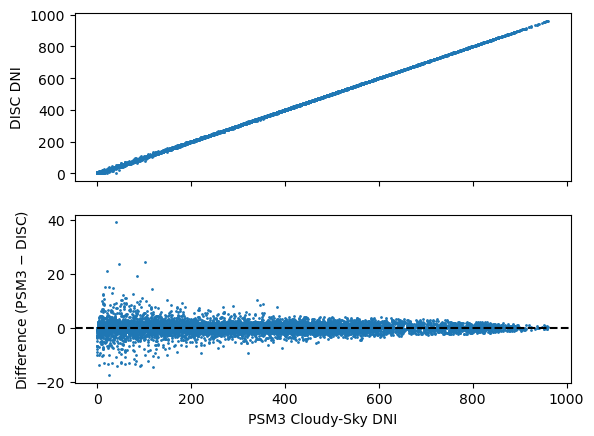

In [5]:
disc = my_disc(cloudy['ghi'], cloudy['solar_zenith'], cloudy.index, cloudy['pressure']*100, min_cos_zenith=0.0, max_zenith=88.765, max_airmass=10e10, sc=1361.2)
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].scatter(cloudy['dni'], disc['dni'], s=1)
axes[0].set_ylabel('DISC DNI')
axes[1].scatter(cloudy['dni'], cloudy['dni'] - disc['dni'], s=1)
axes[1].axhline(0, c='k', ls='--')
axes[1].set_ylabel('Difference (PSM3 $-$ DISC)')
axes[1].set_xlabel('PSM3 Cloudy-Sky DNI')

This is pretty close, but obviously not perfect.  What's the difference?

In [6]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2022-09-22 19:42:51

numpy     : 1.22.3
pvlib     : 0.9.3
pandas    : 1.5.0
matplotlib: 3.5.2

